In [ ]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('titanic/train.csv')
df.Embarked.replace('Q', '', inplace=True)
df.PassengerId = df.PassengerId.astype('string')

In [ ]:
def get_df_info(df: pd.DataFrame, thr: float = 0.01, accur: int = 3):
    '''
    Возвращает поколоночную информацию о датафрейме в другом датафрейме.
    Если датафрейм пустой, вернется None.

    Все колонки имеют тип 'string' (для удобства работы), кроме
    'example_1' и 'example_2', которые имеют тип как в датафреме.

    Параметры
    ----------
    df : pandas датафрейм
    thr : float значение в диапазоне [0, 1]
        До какого значения считать долю медианных элементов
        нормальной. Если доля будет больше указанного значения,
        то будут учавствовать в подсчете trash_score
    accur : int в диапазоне >= 0
        Используется в округлении эначений в датафрейме

    Возвращает
    ----------
        датафрейм с информацией о колонках
    '''
    n, m = len(df), len(df.columns) # table (n x m)
    if n == 0:
        return None

    pd.Series

    # datamining for df_info (everything by columns)
    dtypes = pd.Series(df.dtypes, copy=True)
    unique = df.nunique(dropna=False) # include null
    nan = (1 - df.notnull().sum() / n).round(accur)
    zero = ((df == 0).sum() / n).round(accur)
    empty_str = ((df == '').sum() / n).round(accur)


    mode_v = df.mode(dropna=True).iloc[0] # exclude null
    # get count of elements == mode
    mode_c = [(df.iloc[:,i] == mode_v[i]).sum() / n for i in range(m)]
    mode_c = pd.Series(mode_c).round(accur)

    trash_x1 = nan + zero + empty_str
    trash_x2 = (mode_c > thr) * mode_v
    # apply max((nan + zero + empty_str), mode * (if more than normal))
    trash_score = pd.DataFrame(list(zip(trash_x1, trash_x2)), copy=False).max(axis=1)

    # get two different! examples
    examples = df.sample(2, replace=False)
    example_1 = examples.iloc[0]
    example_2 = examples.iloc[1]


    # change types for replase 0.000 to -1
    replace_dict = {'0.0': '-1'} # replace by dictionary, not by str.replace!
    unique = unique.astype('string').replace(replace_dict)
    nan = nan.astype('string').replace(replace_dict)
    zero = zero.astype('string').replace(replace_dict)
    empty_str = empty_str.astype('string').replace(replace_dict)
    mode_c = mode_c.astype('string').replace(replace_dict)
    trash_score = trash_score.astype('string').replace(replace_dict)

    dtypes = dtypes.astype('string').replace({'string[python]': 'string'})


    # df_info props
    cols = ['dtypes', 'unique', 'nan', 'zero', 'empty_str', 'mode_v', 'mode_c', 'trash_score', 'example_1', 'example_2']
    cols = pd.Series(cols)
    data = list(zip(dtypes, unique, nan, zero, empty_str, mode_v, mode_c, trash_score, example_1, example_2))

    # make and ret df_info
    df_info = pd.DataFrame(data, index=df.columns, columns=cols)
    # sorting in lexicographic order for convenient
    df_info.sort_index(inplace=True)
    return df_info.reindex(sorted(df_info.columns), axis=1)

In [ ]:
# Это реализация
get_df_info(df)

,dtypes,empty_str,example_1,example_2,mode_c,mode_v,nan,trash_score,unique,zero
Age,float64,-1,31.0,31.0,0.034,24.0,0.199,0.199,89,-1
Cabin,object,-1,NaN,NaN,0.004,B96 B98,0.771,0.771,148,-1
Embarked,object,0.086,S,S,0.723,S,0.002,0.088,4,-1
Fare,float64,-1,8.6833,26.25,0.048,8.05,-1,0.017,248,0.017
Name,object,-1,"Osman, Mrs. Mara","Collyer, Mr. Harvey",0.001,"Abbing, Mr. Anthony",-1,-1,891,-1
Parch,int64,-1,0,1,0.761,0.0,-1,0.761,7,0.761
PassengerId,string,-1,798,638,0.001,1,-1,-1,891,-1
Pclass,int64,-1,3,2,0.551,3.0,-1,-1,3,-1
Sex,object,-1,female,male,0.648,male,-1,-1,2,-1
SibSp,int64,-1,0,1,0.682,0.0,-1,0.682,7,0.682


In [ ]:
import matplotlib as mpl
import seaborn as sns

# настройка размера шрифта легенды
mpl.rcParams['legend.title_fontsize'] = 13
mpl.rcParams['legend.fontsize'] = 13

In [ ]:
def plot_density(df: pd.DataFrame, hue: str, cols = None, max_cat_thr: int = 20, drop_zero = True):
    '''
    Рисует распределения колонок cols.
    Если колонка не числового типа и не является категориальной (уникальных элементов >= max_cat_thr)
    , то в отрисовке не участвует. Существует 2 типа графиков: для числовых стобцов и категориальных.

    Если столбец числовой, но уникальных элементов < max_cat_thr, то для него будет все равно применен
    катерогиальный тип.

    Параметры
    ----------
    cols: отрисовываемые колонки. Если None, то рисуем df.columns (кроме hue)

    max_cat_thr: до какого количества уникальных элементов считать
        колонку категориальной

    drop_zero: учавствуют ли в отрисовке значения равные нулю.

    '''
    # columns for drawing (exept hue)
    draw_cols = []

    # filter1: all columns or all exept cols
    if cols == None:
        draw_cols = df.columns.drop(hue)
    else:
        draw_cols = df.columns.intersect(cols).drop(hue)

    # filter2: exclude not category columns
    drops = []
    for draw_col in draw_cols:
        is_numeric = pd.api.types.is_numeric_dtype(df[draw_col])
        is_category = len(pd.unique(df[draw_col])) < max_cat_thr

        if not is_category and not is_numeric:
            drops.append(draw_col)

    draw_cols = draw_cols.drop(drops)

    # types of fontsize
    BIG_FS = 25
    NORMAL_FS = 20
    SMALL_FS = 15
    # for stripplot
    MAX_SAMPLES = 400
    WH = (24, 7) # width and height plots (in inches)

    # functions for drawing
    def plot_density_numeric(df: pd.DataFrame, hue: str, col: str):
        # create dataframe for barplot
        group_c = df.groupby(hue).size()
        hue_col = pd.unique(df[hue])

        # create df with zero value statistic by hue
        zero_group_c = (df[df[col] == 0].groupby(hue).size() / group_c).round(3)
        df1 = pd.DataFrame(zero_group_c)
        df1.rename(columns={0: 'y'}, inplace=True)
        df1['x'] = pd.Series([0] * len(hue_col))
        df1[hue] = hue_col

        # create df with NaN value statistic by hue
        null_group_c = (df[df[col].isnull()].groupby(hue).size() / group_c).round(3)
        df2 = pd.DataFrame(null_group_c)
        df2.rename(columns={0: 'y'}, inplace=True)
        df2['x'] = pd.Series(['NaN'] * len(hue_col))
        df2[hue] = hue_col

        # concatenate in one dataframe
        df_barplot = pd.concat([df1, df2])
        df_barplot["y"].fillna(-0.05 * max(df_barplot["y"].max(), 0), inplace = True)

        draw_df = df
        # filter zero values
        if drop_zero:
            draw_df = df.loc[df[col] != 0]

        fig, ax = mpl.pyplot.subplot_mosaic('abc')

        # setting ax by seaborn
        sns.histplot(data=draw_df,
                     bins=24, # count columns
                     discrete=False, # count columns == count different values in x axis
                     fill=True, # fill columns inside?
                     x=col, # column name for x axies values
                     multiple='stack', # don't mix hue
                     element='step', # without wertical lines
                     stat='count', # yi = cnt(df[col] == xi)
                     alpha=0.7, # color brightness
                     hue=hue,
                     ax=ax['a']) # ax for setting by sboarn

        # setting ax by matplotlib
        ax['a'].set_title("stat='count'", fontsize=NORMAL_FS) # set title in current ax
        ax['a'].tick_params(axis='both', labelsize=SMALL_FS) # set font-size of values on axies
        ax['a'].set_xlabel('', fontsize=0) # hide axies labels
        ax['a'].set_ylabel('', fontsize=0)
        ax['a'].legend([],[], frameon=False) # hide list hue

        sns.barplot(data=df_barplot, x='x', y='y', hue=hue, edgecolor='black', ax=ax['b'])
        ax['b'].set_title('', fontsize=0)
        ax['b'].legend(fontsize=BIG_FS, title=hue, title_fontsize=BIG_FS) # change legend size and title legend size
        ax['b'].axhline(0, color='black', ls='--') # underscore zero value
        ax['b'].grid(True, axis='y') # add grid
        ax['b'].tick_params(axis='both', labelsize=NORMAL_FS)
        ax['b'].set_xlabel('', fontsize=0)
        ax['b'].set_ylabel('', fontsize=0)

        # draw two plots on one ax
        sns.boxenplot(data=draw_df,
                      x=hue,
                      y=col,
                      showfliers=False, # we show fliers in stripplot (if they get into samples-set)
                      dodge=False, # dodge other plots?
                      hue=hue,
                      ax=ax['c'])
        sns.stripplot(data=draw_df.sample(min(MAX_SAMPLES, len(draw_df))),
                      x=hue,
                      y=col,
                      palette='dark:black', # color theme
                      size=4, # width point
                      hue=hue,
                      ax=ax['c'])

        ax['c'].set_title('showfliers=False', fontsize=NORMAL_FS)
        ax['c'].tick_params(axis='both', labelsize=SMALL_FS)
        ax['c'].set_xlabel('', fontsize=0)
        ax['c'].set_ylabel('', fontsize=0)
        ax['c'].legend([],[], frameon=False)

        # setting figure
        fig.suptitle(col + ' vs "' + hue + '"', fontsize=BIG_FS)
        fig.set_size_inches(WH) # width and height
        fig.tight_layout()
        fig.subplots_adjust(top=0.82) # offset


    def plot_density_category(df: pd.DataFrame, hue: str, col: str):
        fig, ax = mpl.pyplot.subplot_mosaic('aaa')

        # replace empty string and NaN to string
        filtered_col = df[col].fillna('<NaN>').replace(r'^\s*$', '<Empty>', regex=True)
        hue_col = df[hue]
        df_countplot = pd.DataFrame([hue_col, filtered_col]).transpose()
        df_countplot.rename(columns={0: hue, 1: col}, inplace=True)

        # setting
        sns.countplot(data=df_countplot, edgecolor='black', x=col,  hue=hue, ax=ax['a'])
        ax['a'].set_title('straight hue', fontsize=NORMAL_FS)
        ax['a'].grid(True, axis='y') # add grid
        ax['a'].legend(fontsize=BIG_FS, title=hue, title_fontsize=BIG_FS) # change legend size and title legend size
        ax['a'].set_xlabel('', fontsize=0)
        ax['a'].set_ylabel(ax['a'].get_ylabel(), fontsize=NORMAL_FS)
        ax['a'].tick_params(axis='both', labelsize=NORMAL_FS)
        ax['a'].tick_params(axis='x', rotation=90) # rotate tick x values

        # setting figure
        fig.suptitle(col + ' vs "' + hue + '"', fontsize=BIG_FS)
        fig.set_size_inches(WH) # width and height
        fig.tight_layout()
        fig.subplots_adjust(top=0.82) # offset


    # call functions on depend type
    for col in draw_cols:
        is_numeric = pd.api.types.is_numeric_dtype(df[col])
        is_category = len(pd.unique(df[col])) < max_cat_thr

        if is_category:
            plot_density_category(df, hue, col)
        elif is_numeric:
            plot_density_numeric(df, hue, col)

    mpl.pyplot.show()

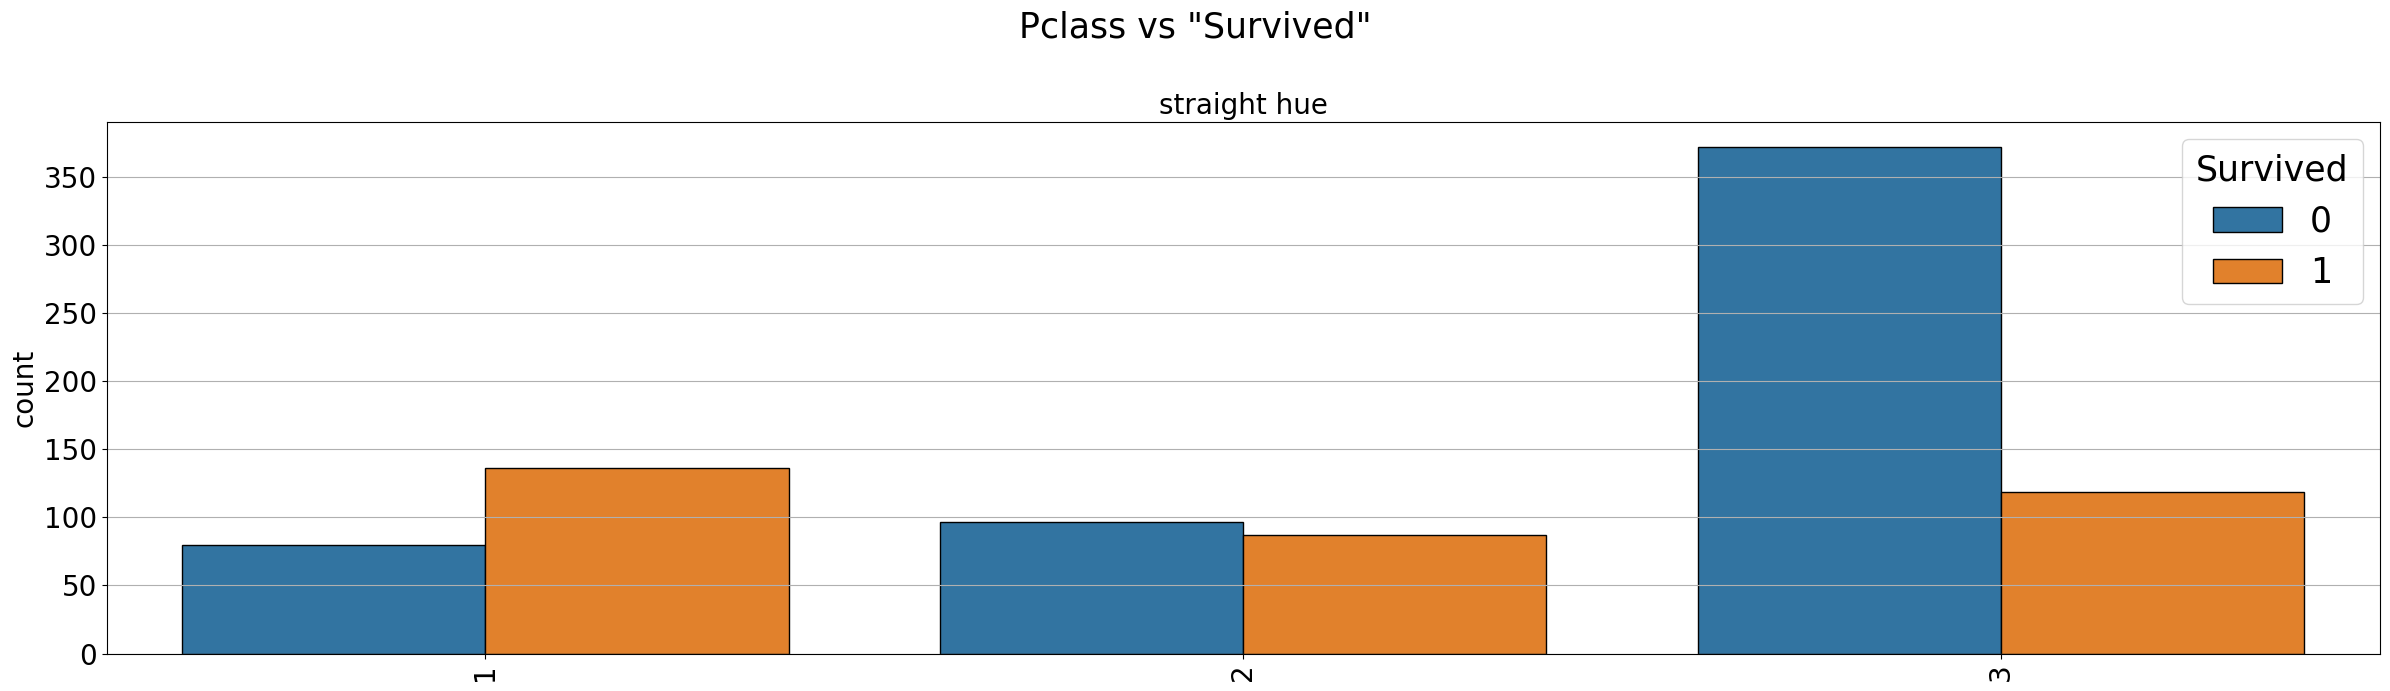

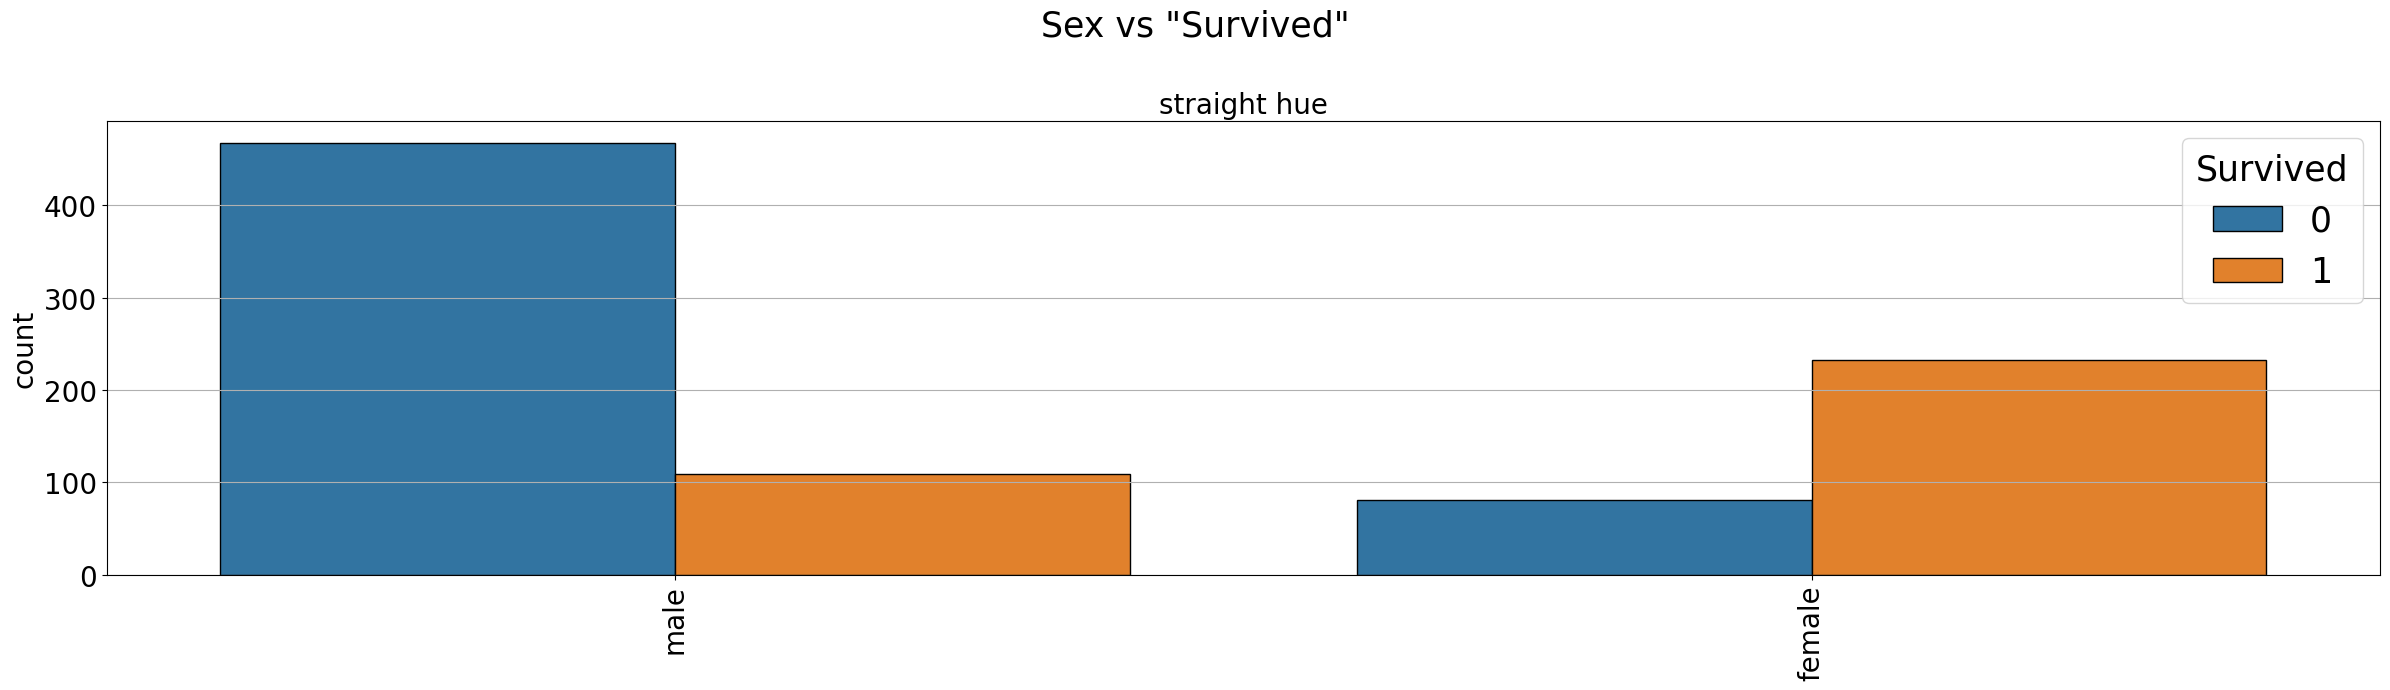

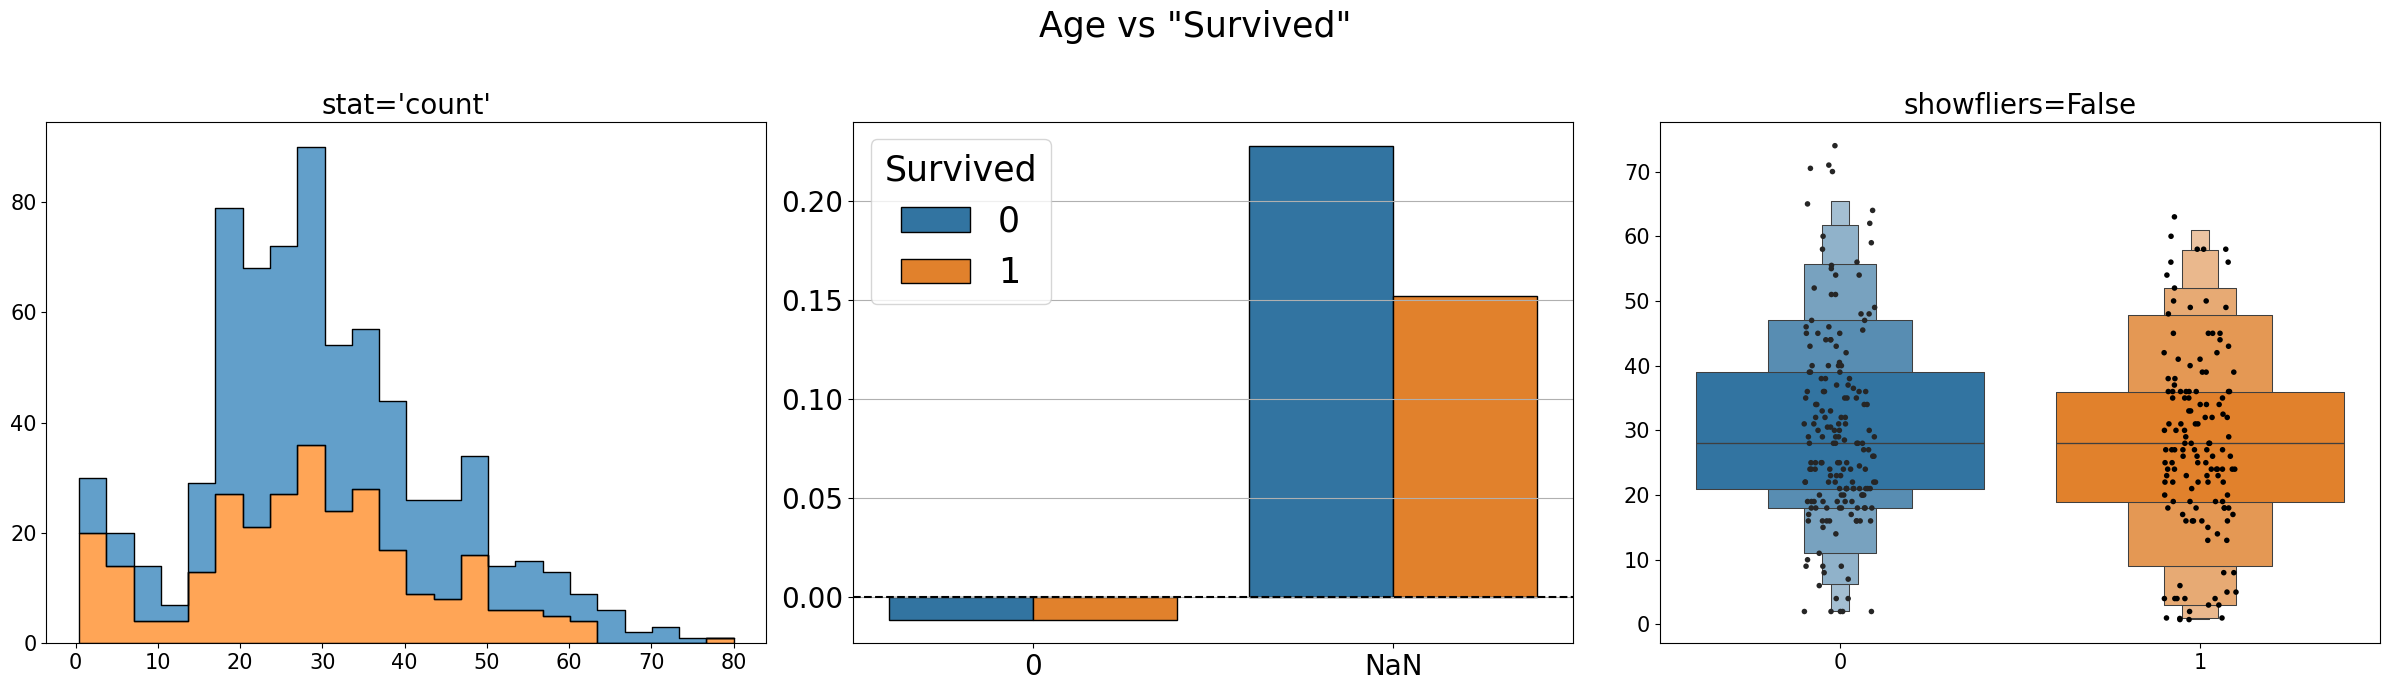

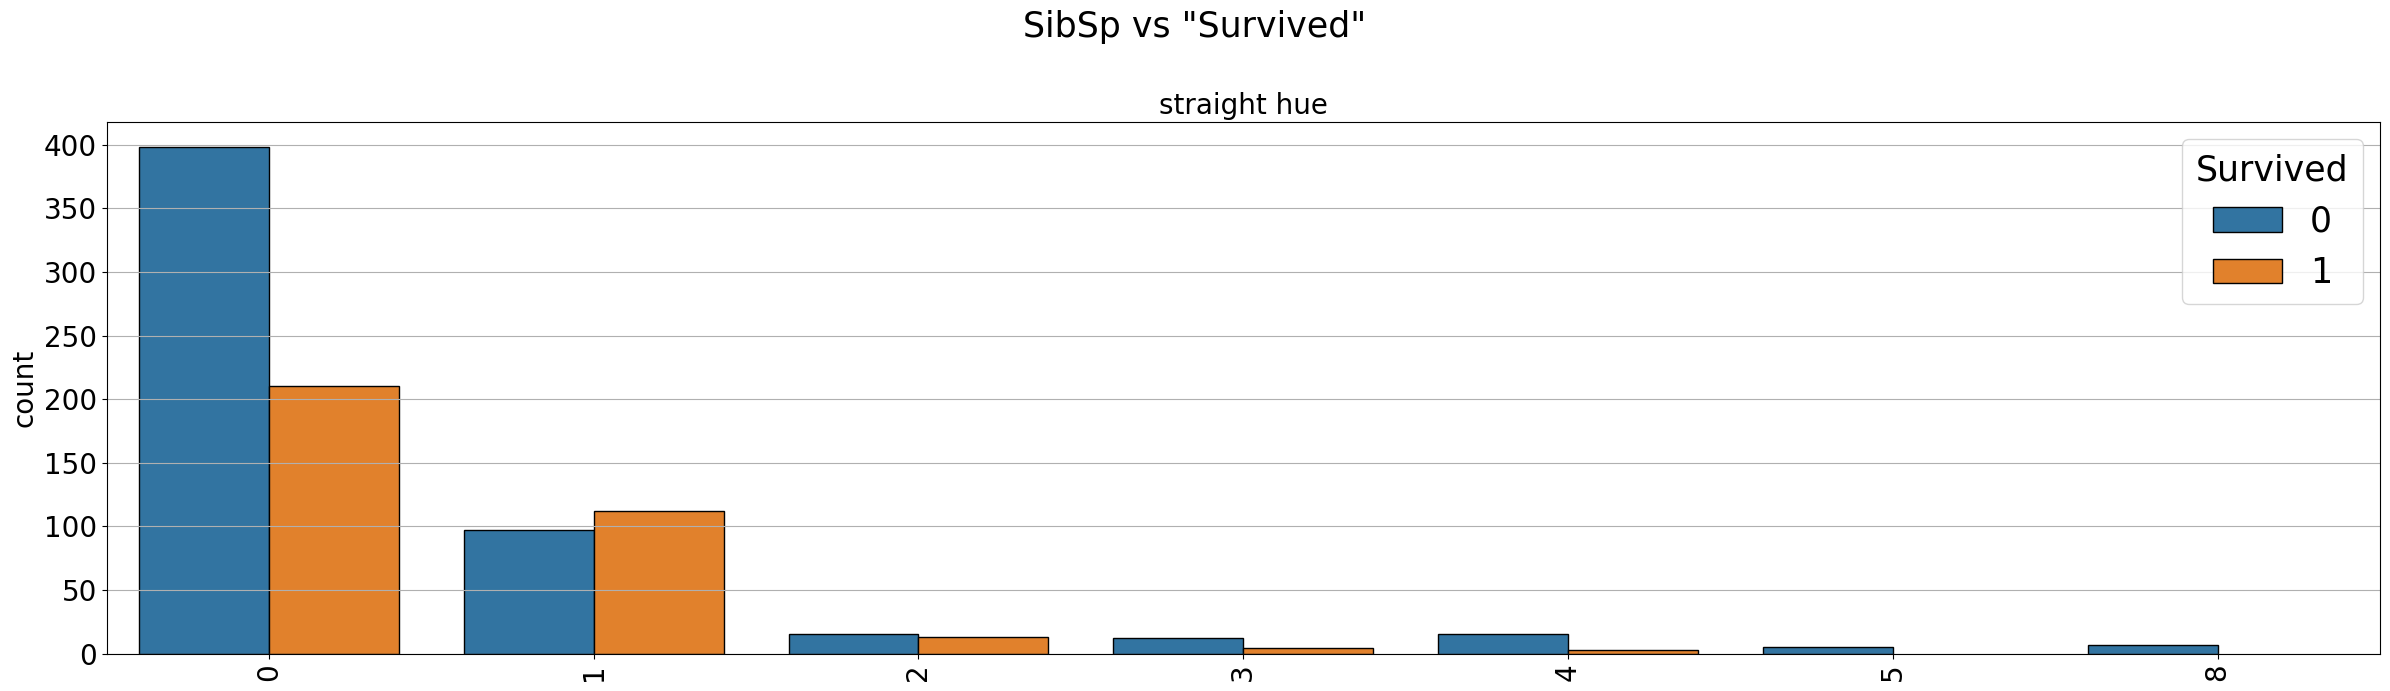

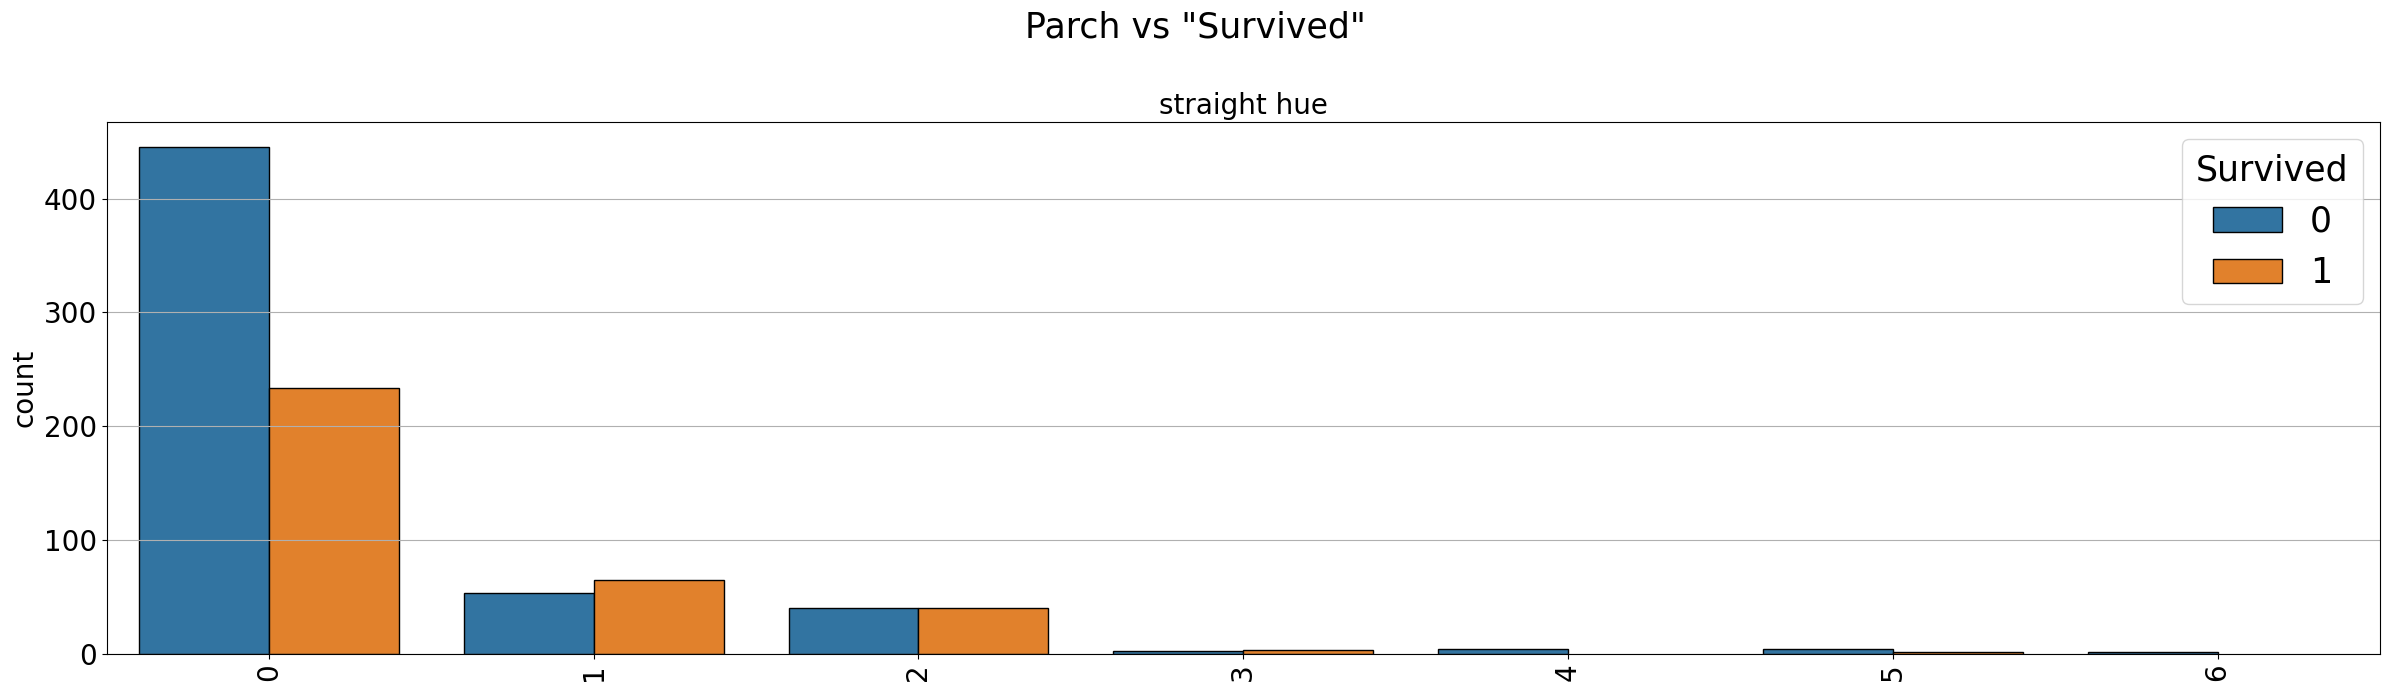

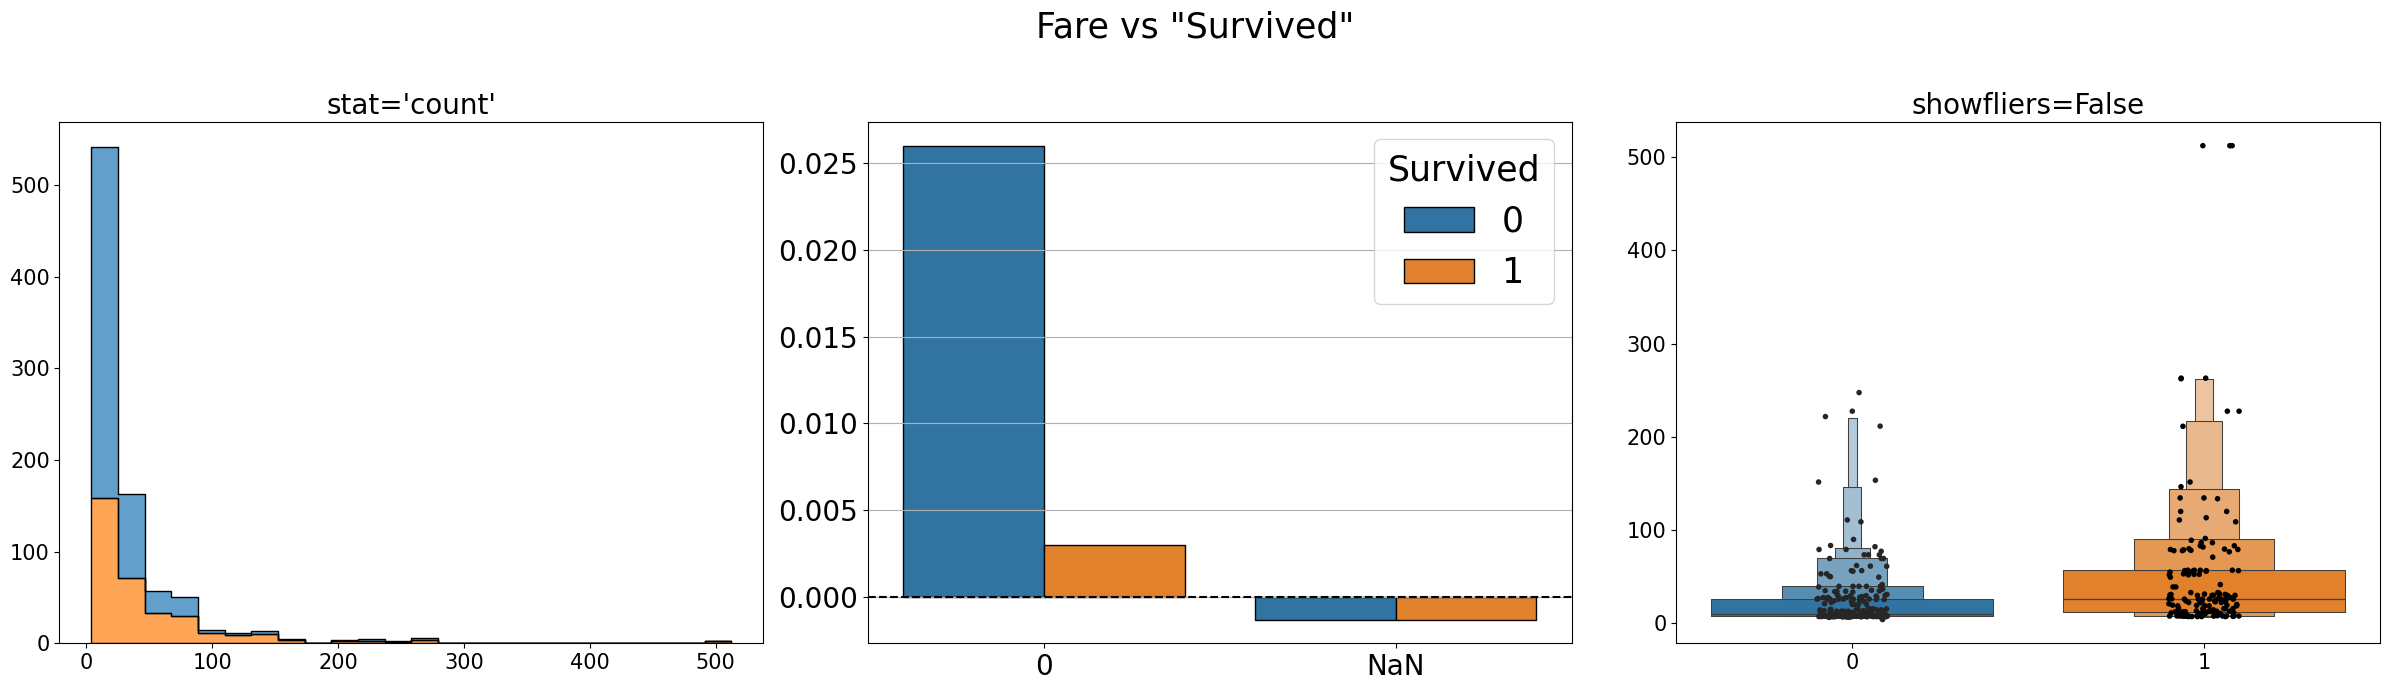

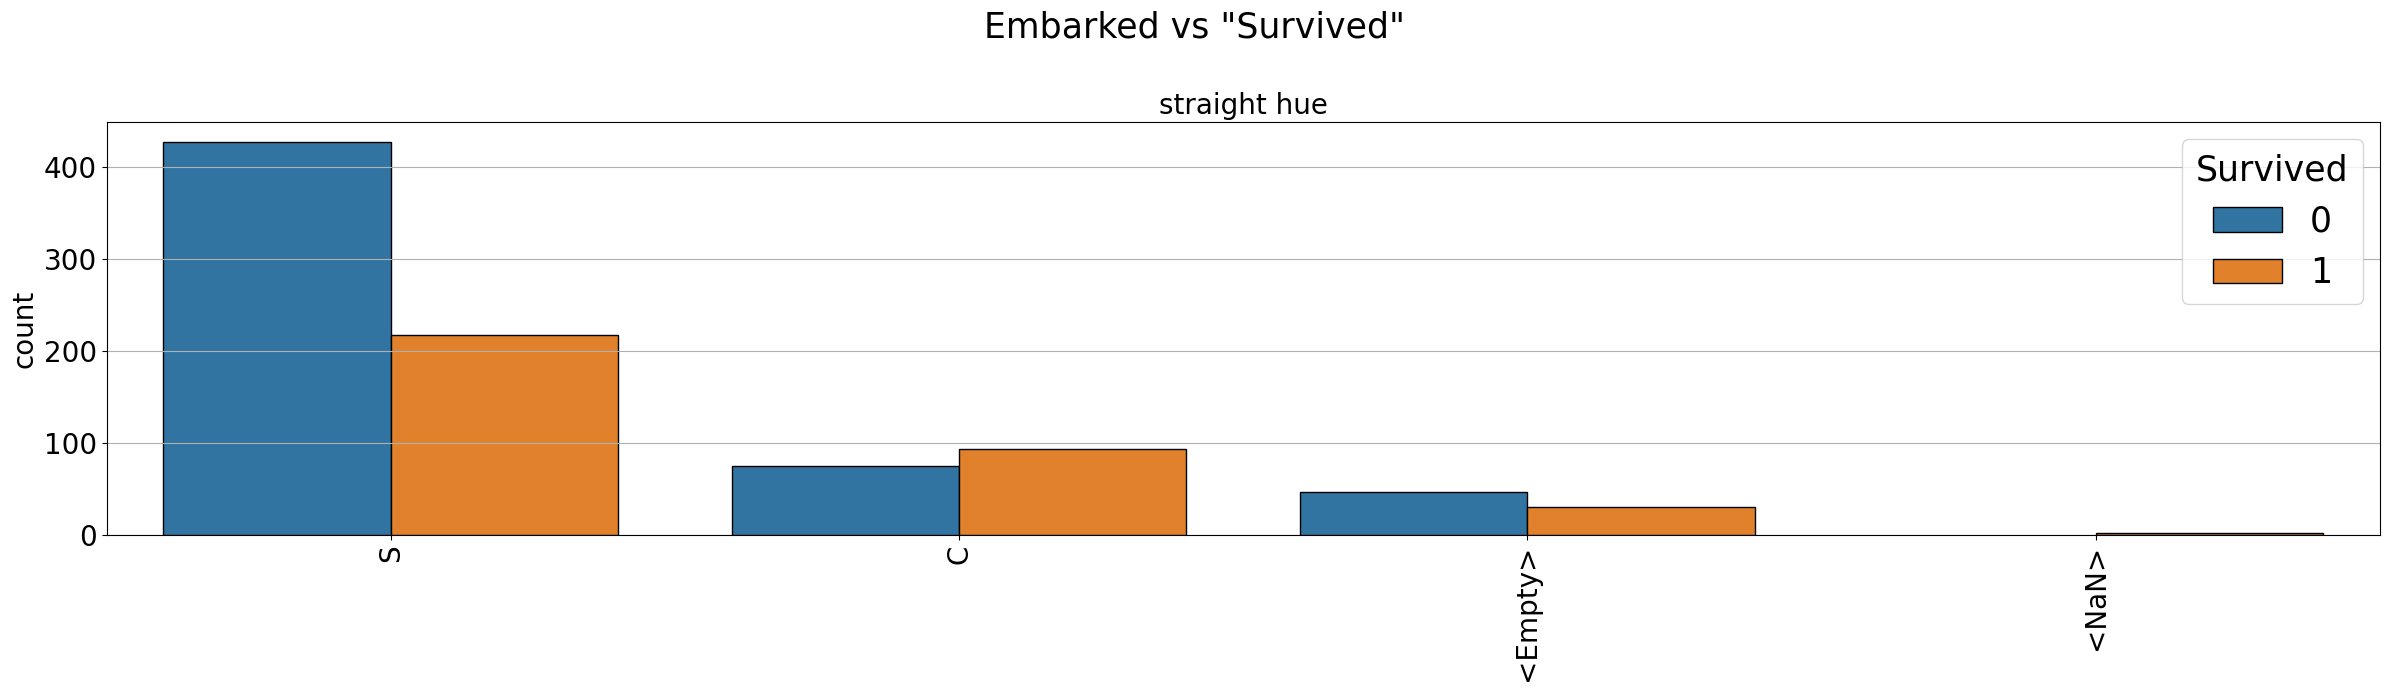

In [ ]:
# Это реализация, запускайте
plot_density(df, hue='Survived')

***Вопрос:*** Как вы думаете, какие проблемы с этой рисовалкой могут возникнуть при применении ее на других датасетах?

1) на графиках sns.boxenplot + sns.stripplot в выборку к stripplot может попасться выброс
 и boxenplot будет слабо различим (даже сейчас проявляется такая проблема)

2) в моей рисовалке в sns.histplot не регулируется число бинов. Могут быть в одной области слишком плотные данные для
данного числа бинов. В таком случае мы не увидим как на самом деле ведут себя значения в такой области,
поскольку все "слипнется".

3) не хватает логарифмического масштаба, он явно пригодится

4) хоть и нигде нет копирования всего датафрема. Происходят копирования отдельных столбцов и их обработка. Что может
сказаться на производительности